In [2]:
import os
import json
import pandas as pd
from sklearn.model_selection import train_test_split

# Paths
photos_path = r"C:\Users\oscar\Downloads\DL\photos"
label_file = r"C:\Users\oscar\Downloads\DL\photos.json"

# Attempt to load as JSON lines format
labels = []
with open(r"C:\Users\oscar\Downloads\DL\photos.json", 'r') as f:
    for line in f:
        labels.append(json.loads(line))

# Convert list of dictionaries to DataFrame
labels = pd.DataFrame(labels)

# Split into train and test sets
train_labels, test_labels = train_test_split(labels, test_size=0.2, random_state=42)


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import pandas as pd
import json
import os

# Load the JSON file
with open('C:\\Users\\oscar\\Downloads\\DL\\photos.json', 'r') as file:
    lines = file.readlines()

# Convert each line to a dictionary and then to a DataFrame
data = pd.DataFrame([json.loads(line) for line in lines])

image_files = os.listdir('C:\\Users\\oscar\\Downloads\\DL\\photos')
print("First 5 image files in directory:", image_files[:5])
print("\nFirst 5 photo_ids in data:", data['photo_id'].head())

# Add .jpg extension to photo_ids to match actual filenames
data['filename'] = data['photo_id'] + '.jpg'

# Split into train and test
train_labels = data.iloc[:len(data)//2]
test_labels = data.iloc[len(data)//2:]

# Image size and augmentation settings
IMG_SIZE = 224

train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    rotation_range=15,
    horizontal_flip=True,
    preprocessing_function=lambda img: cv2.GaussianBlur(img, (3, 3), 0)  # Gaussian Blur
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Apply transformations for train and test data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory='C:\\Users\\oscar\\Downloads\\DL\\photos',
    x_col="filename",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_labels,
    directory='C:\\Users\\oscar\\Downloads\\DL\\photos',
    x_col="filename",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical'
)

print("Number of training samples:", len(train_generator))
print("Number of test samples:", len(test_generator))

First 5 image files in directory: ['--0h6FMC0V8aMtKQylojEg.jpg', '--3JQ4MlO-jHT9xbo7liug.jpg', '--3P3fjPrScy06XVLi4vhg.jpg', '--4DfhW2sJvjeC90KEDX3g.jpg', '--5V3mRlhb3zqE5yF4Gpaw.jpg']

First 5 photo_ids in data: 0    zsvj7vloL4L5jhYyPIuVwg
1    HCUdRJHHm_e0OCTlZetGLg
2    vkr8T0scuJmGVvN2HJelEA
3    pve7D6NUrafHW3EAORubyw
4    H52Er-uBg6rNrHcReWTD2w
Name: photo_id, dtype: object
Found 100050 validated image filenames belonging to 5 classes.
Found 100050 validated image filenames belonging to 5 classes.
Number of training samples: 3127
Number of test samples: 3127


In [5]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

# Load VGG16 with all layers trainable
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

for layer in base_model.layers:
    layer.trainable = True

# Custom classification layers
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
output = Dense(len(train_generator.class_indices), activation='softmax')(x)  # Use len(train_generator.class_indices)

# Define model
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['AUC'])

In [6]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from PIL import Image
import os

def validate_image(filepath):
    try:
        img = Image.open(filepath)
        img.verify()
        return True
    except:
        return False

# Filter valid images
valid_train_labels = train_labels[train_labels['filename'].apply(
    lambda x: validate_image(os.path.join('C:\\Users\\oscar\\Downloads\\DL\\photos', x))
)]
valid_test_labels = test_labels[test_labels['filename'].apply(
    lambda x: validate_image(os.path.join('C:\\Users\\oscar\\Downloads\\DL\\photos', x))
)]

print(f"Valid training images: {len(valid_train_labels)}")
print(f"Valid test images: {len(valid_test_labels)}")

# Recreate generators with validated data
BATCH_SIZE = 16
IMG_SIZE = 224

train_generator = train_datagen.flow_from_dataframe(
    dataframe=valid_train_labels,
    directory='C:\\Users\\oscar\\Downloads\\DL\\photos',
    x_col="filename",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    validate_filenames=True
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=valid_test_labels,
    directory='C:\\Users\\oscar\\Downloads\\DL\\photos',
    x_col="filename",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    validate_filenames=True
)

# Redefine model with smaller architecture
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
output = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile with CPU-friendly settings
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True
)

# Training settings
EPOCHS = 3
# Calculate steps based on valid images
STEPS_PER_EPOCH = min(50, len(valid_train_labels) // BATCH_SIZE)
VALIDATION_STEPS = min(25, len(valid_test_labels) // BATCH_SIZE)

# Train the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    callbacks=[early_stopping, model_checkpoint]
)

# Prediction settings
MAX_PRED_SAMPLES = min(500, len(valid_test_labels))
predictions = model.predict(
    test_generator,
    steps=min(MAX_PRED_SAMPLES // BATCH_SIZE, len(test_generator))
)

# Get actual labels for the predicted subset
true_labels = test_generator.classes[:len(predictions)]
predicted_labels = np.argmax(predictions, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

Valid training images: 100000
Valid test images: 99994
Found 100000 validated image filenames belonging to 5 classes.
Found 99994 validated image filenames belonging to 5 classes.


c:\Users\oscar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 673s 13s/step - accuracy: 0.5152 - loss: 1.2209 - val_accuracy: 0.7625 - val_loss: 0.7862
Epoch 2/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 676s 14s/step - accuracy: 0.7480 - loss: 0.7408 - val_accuracy: 0.6825 - val_loss: 0.8399
Epoch 3/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 668s 13s/step - accuracy: 0.7270 - loss: 0.7286 - val_accuracy: 0.7650 - val_loss: 0.6084
31/31 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step


NameError: name 'confusion_matrix' is not defined

In [7]:
from sklearn.metrics import confusion_matrix 

In [8]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[  0  20  20   0   0]
 [  0 146 109   0   0]
 [  0  72  60   0   0]
 [  0   0   3   0   0]
 [  0  38  28   0   0]]


In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

BATCH_SIZE = 32
EPOCHS = 3

# Significantly reduce steps for faster training
STEPS_PER_EPOCH = 20    
VALIDATION_STEPS = 10   

# More aggressive early stopping and LR reduction
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    min_delta=0.01 
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,       
    patience=1,       
    min_lr=0.00001
)

# Compile with AUC
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['AUC']
)

# Train with reduced steps
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 271s 13s/step - AUC: 0.7118 - loss: 12.1106 - val_AUC: 0.8614 - val_loss: 1.0797 - learning_rate: 0.0010
Epoch 2/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 269s 14s/step - AUC: 0.8111 - loss: 1.2138 - val_AUC: 0.8226 - val_loss: 1.1668 - learning_rate: 0.0010
Epoch 3/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 265s 13s/step - AUC: 0.8254 - loss: 1.1602 - val_AUC: 0.8343 - val_loss: 1.1682 - learning_rate: 2.0000e-04


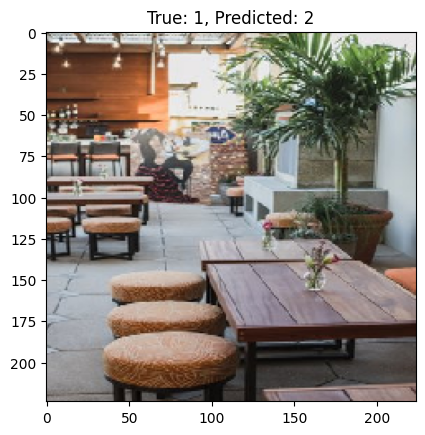

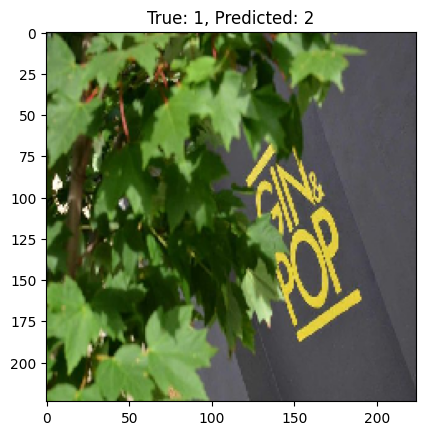

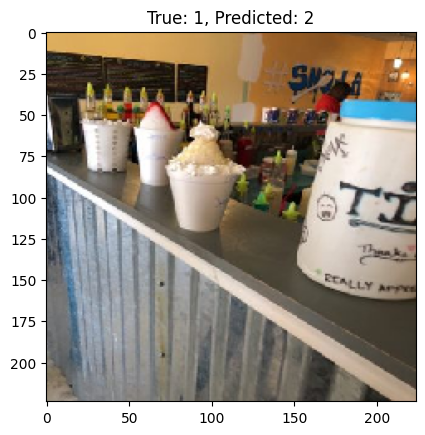

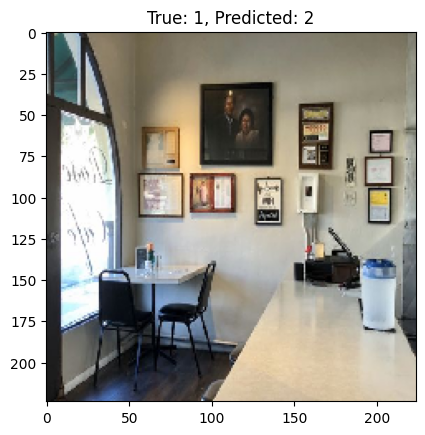

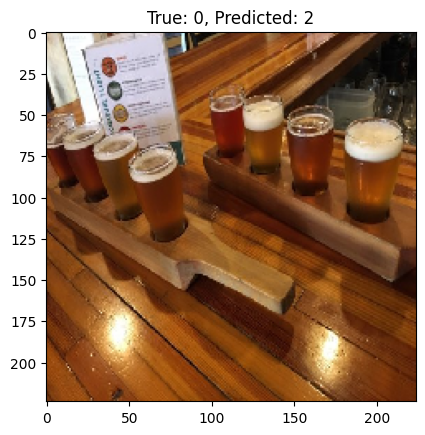

In [12]:
import matplotlib.pyplot as plt

# Display a few misclassified images
misclassified_indices = np.where(predicted_labels != true_labels)[0]
for idx in misclassified_indices[:5]: 
    img_batch, label_batch = test_generator[idx]
    img = img_batch[0] 
    true_label = true_labels[idx]
    pred_label = predicted_labels[idx]
    plt.imshow(img)
    plt.title(f"True: {true_label}, Predicted: {pred_label}")
    plt.show()